In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev
from scipy.stats import norm, logistic
from scipy.special import erf
import seaborn as sns; sns.set()

# MIEDŹ

## Ceny miedzi na przestrzeni 5 lat (Open) (cena za nie wiem jaką ilość)

In [2]:
copper = pd.read_csv('copper.csv', sep = ',', encoding = 'latin-1')
copper

,Date,Close/Last,Volume,Open,High,Low
0,03/28/2023,4.0855,75067,4.0970,4.1130,4.0590
1,03/27/2023,4.0785,65558,4.0750,4.1020,4.0235
2,03/24/2023,4.0750,82229,4.1015,4.1485,4.0505
3,03/23/2023,4.1235,77824,4.0430,4.1265,4.0225
4,03/22/2023,4.0445,77119,4.0015,4.1075,3.9715
...,...,...,...,...,...,...
1254,04/05/2018,3.0745,107499,3.0285,3.0880,3.0135
1255,04/04/2018,3.0105,137745,3.0670,3.0695,2.9700
1256,04/03/2018,3.0635,109250,3.0445,3.0695,3.0385
1257,04/02/2018,3.0500,68976,3.0480,3.0725,3.0370


In [94]:
def draw_stock(df, clr):
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1]
    prices = df['Open'].values[::-1]
    plt.plot(dates, prices, color = clr)
    plt.ylabel('USD')
    plt.show()

## Wykres cen miedzi

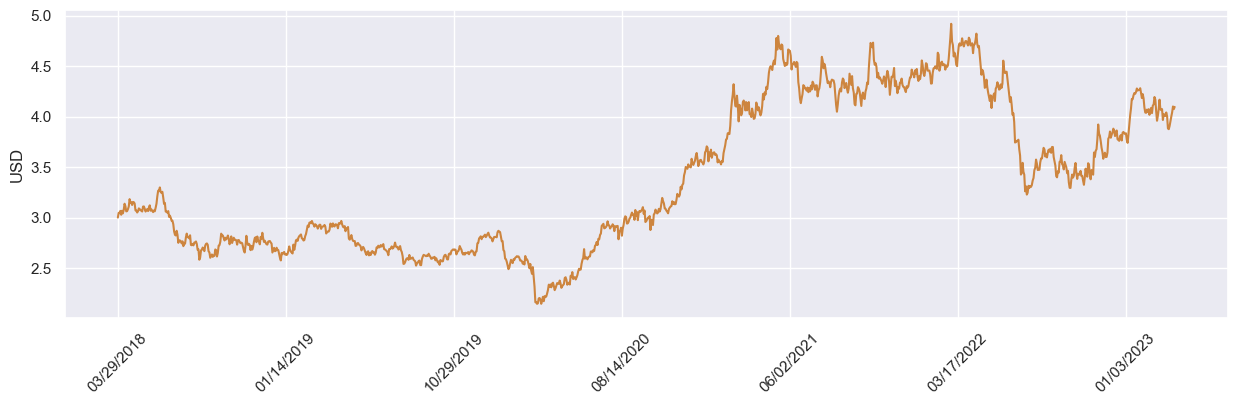

In [95]:
draw_stock(copper, 'peru')

## Histogram logarytmicznych przyrostów

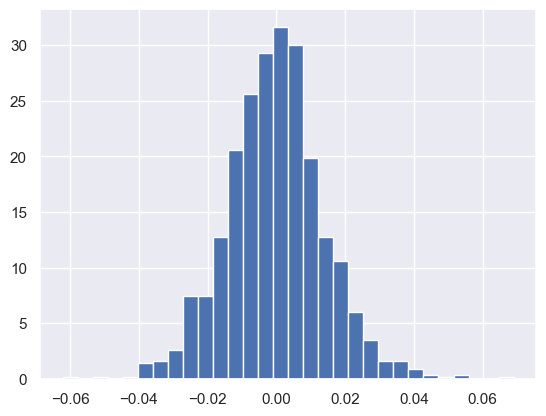

In [3]:
s = np.array(copper['Open'].values[1:])
s2 = np.array(copper['Open'].values[:-1])
r = np.log(s/s2)
plt.hist(r, bins = 30, density = True)
plt.show()

## Miary zmienności ryzyka

Z danych generujemy histogram i staramy się do niego dopasować rozkład. Na początku próbujemy z rozkładem normalnym, jednak ten nie jest najlepiej dopasowany. Udaje nam się znaleźć lepszą propozycję - rozkład logistyczny.

In [10]:
#Porównanie histogramu z wykresami funkcji gęstości
def norm_kde(x, mi, sigma):
    x = np.array(sorted(x))
    y = norm.pdf(x, mi, sigma) #rozkład normalny
    y2 = logistic.pdf(x, mi, math.sqrt(3)/math.pi*sigma) #rozkład logistyczny
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1) 
    plt.plot(x, y, color = 'blue', label = 'normal pdf')
    plt.plot(x, y2, color = 'green', label = 'logistic pdf')
    plt.hist(x, bins = 50, density = True, color = 'white', ec = 'black')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.show()

In [11]:
#Porównanie dystrybuant teoretycznych z dystrybuantą empiryczną
def cdf(x, mi, sigma):
    x = np.array(sorted(x))
    y = norm.cdf(x, mi, sigma)
    y2 = logistic.cdf(x, mi, math.sqrt(3)/math.pi*sigma)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(x, y, color = 'red', label = 'CDF', linestyle = 'dashdot')
    plt.plot(x, y2, color = 'blue', label = 'Logistic cdf', linestyle = 'dashdot')
    sns.ecdfplot(data = x, color = 'black', label = 'ECDF', alpha = 0.4)
    plt.xlabel('x')
    plt.ylabel('F(x)')
    plt.legend()
    plt.show()

In [12]:
mu = np.mean(r)
s = stdev(r)
print('Średnia: ' + str(mu))
print('Odchylenie standardowe: ' + str(s))

Średnia: -0.00024746377750914307
Odchylenie standardowe: 0.014277995279475233


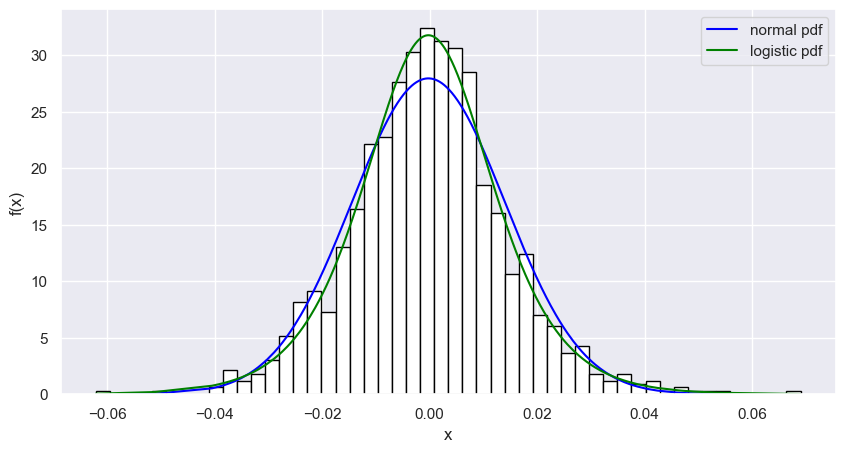

In [14]:
norm_kde(r, mu, s)

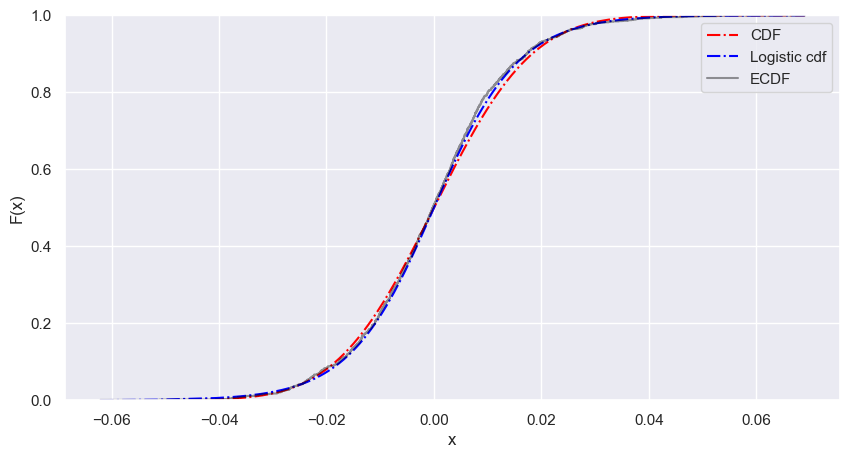

In [9]:
cdf(r, 0, s)

## Porównanie kwantyli (parametryczne i nieparametryczne) 95%, 97.5% i 99%

In [71]:
def comp_quantile(x, p1, p2, p3): #p ma być z zakresu [0, 1]
    mi = np.mean(x)
    sigma = stdev(x)
    p = [p1, p2, p3]
    real = np.quantile(x, p)
    nrm = norm.ppf(p, mi, sigma)
    lgstc = logistic.ppf(p, mi, math.sqrt(3)/math.pi*sigma)
    perc = [format(p, '.2%') for p in [p1, p2, p3]]
    dct = {'p' : perc, 'real' : real, 'normal' : nrm, 'logistic' : lgstc}
    df = pd.DataFrame(dct)
    return df

In [73]:
comp_quantile(r, .95, .975, .99)

,p,real,normal,logistic
0,95.00%,0.023474,0.023238,0.022931
1,97.50%,0.028719,0.027737,0.028592
2,99.00%,0.037611,0.032968,0.035925


## Wartości dystrybuanty

In [66]:
min(r)

-0.06210891899980478

In [67]:
max(r)

0.06900828562634184

Sprawdzimy wartości dystrybuant dla $x \in \{-0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05\}$

In [76]:
def comp_dist(x, x0 = [-0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05]):
    x = sorted(x)
    mi = np.mean(x)
    sigma = stdev(x)
#     real = [np.linspace(0, 1, len(x))]
    nrm = norm.cdf(x0, mi, sigma)
    lgstc = logistic.cdf(x0, mi, sigma)
    dct = {'x0' : x0, 'normal' : nrm, 'logistic' : lgstc}
    df = pd.DataFrame(dct)
    return df

In [77]:
comp_dist(r)

,x0,normal,logistic
0,-0.05,0.000246,0.029755
1,-0.03,0.018589,0.110681
2,-0.01,0.247289,0.335582
3,0.00,0.506914,0.504333
4,0.01,0.763532,0.672103
5,0.03,0.982932,0.892685
6,0.05,0.999784,0.971230


# ALUMINIUM

## Ceny aluminium (Open) (w USD za tonę)

In [100]:
aluminium = pd.read_csv('aluminium.csv', sep = ',', encoding = 'latin-1')
aluminium

,Date,Close/Last,Volume,Open,High,Low
0,04/12/2023,2328.50,1205.0,2311.00,2335.0,2293.50
1,04/11/2023,2306.75,1979.0,2333.75,2335.5,2302.50
2,04/10/2023,2348.00,2215.0,2348.00,2348.0,2348.00
3,04/06/2023,2338.25,1373.0,2355.00,2359.5,2329.25
4,04/05/2023,2370.00,NaN,2370.00,2370.0,2370.00
...,...,...,...,...,...,...
1254,04/19/2018,2300.00,NaN,2300.00,2300.0,2300.00
1255,04/18/2018,2300.00,NaN,2300.00,2300.0,2300.00
1256,04/17/2018,2300.00,NaN,2300.00,2300.0,2300.00
1257,04/16/2018,2300.00,NaN,2300.00,2300.0,2300.00


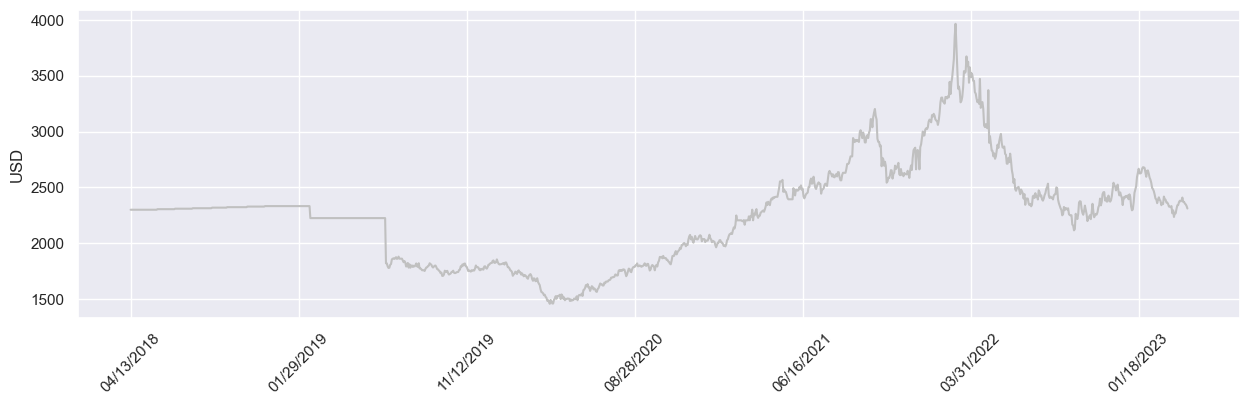

In [101]:
draw_stock(aluminium, 'silver')